In [54]:
%alias nbconvert nbconvert ./Block.ipynb

In [55]:
%nbconvert

[NbConvertApp] Converting notebook ./Block.ipynb to python


In [51]:
import logging
import textwrap
from random import randrange
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

try:
    from . import constants
except ImportError as e:
    import constants

In [4]:
class Block:
    def __init__(self, area=(600, 448), hcenter=False, vcenter=False, rand=False, abs_coordinates=(0,0),
                 padding=0):
        '''Base constructor for Block Class.
        
        Args:
            image (PIL.Image): Image to be formatted and resized to fit within
                area
            area (:obj:`tuple` of :obj: `int`): x, y integer dimensions of 
                maximum area in pixles
            abs_coordinates (:obj:`tuple` of `int`): x, y integer coordinates of image area
                within a larger image
            hcenter (boolean, optional): True - horizontal-align image within the area, 
                False - left-align image
            vcenter (boolean, optional): True - vertical-align image within the area,
                False - top-align image\
            rand (boolean, optional): True - ignore vcenter, hcenter choose random position for
                image within area
            padding (int, optional): amount of padding between resized image and edge of area'''
        
        self.area = area
        self.padding = padding
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.rand = rand
        self.abs_coordinates = abs_coordinates
    
    
    @property
    def area(self):
        ''':obj:`tuple` of :obj:`int`: maximum area of imageblock'''        
        return self._area

    @area.setter
    def area(self, area):
        if self._coordcheck(area):
            self._area = area
            logging.debug(f'maximum area: {area}')
        else:
            raise ValueError(f'bad area value: {area}')    
    
    @property
    def abs_coordinates(self):
        ''':obj:`tuple` of :obj:`int`: absolute_coordinates of area within larger image.
        
        Setting `abs_coordinates` atomatically sets `img_coordinates` to the same value.
        '''
        return self._abs_coordinates
    
    @abs_coordinates.setter
    def abs_coordinates(self, abs_coordinates):
        if self._coordcheck(abs_coordinates):
            self._abs_coordinates = abs_coordinates
            self.img_coordinates = abs_coordinates
            logging.debug(f'absolute coordinates: {abs_coordinates}')
        else:
            raise ValueError(f'bad absoluote coordinates: {abs_coordinates}')
    
    def update(self, update=None):
        '''Update contents of object.
        
        Method is used to easily update image blocks
        
        Args:
            update (:obj:): data
            
        Returns:
            bool: True upon success'''
        return True
    
    def _coordcheck(self, coordinates):
        '''Check that coordinates are of type int and positive.

        Args:
            coordinates (:obj:`tuple` of :obj: `int`)

        Raises:
            TypeError: `coordinates` are not a list or tuple
            TypeError: `coordinates` elements are not an integer
            ValueError: `coordinates` are not >=0
        '''
        if not isinstance(coordinates, (tuple, list)):
            raise TypeError(f'must be type(list, tuple): {coordinates}')
        for i, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'must be type(int): {c}')
                return False
            if c < 0:
                raise ValueError(f'coordinates must be positive: {c}')
                return False
        return True

In [5]:
class ImageBlock(Block):
    def __init__(self, image=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        logging.info(f'create ImageBlock')
        self.image = image
        
    @property
    def image(self):
        ''':obj:`PIL.Image`: resizes, and centers image to fit within the `area`
        
        Setting/Updating `image` recalculates `img_coordinates`'''
        return self._image
    
    @image.setter
    def image(self, image):
        if not image:
            logging.debug(f'setting empty 1x1 image')
            self._image = Image.new('1', (1, 1), 255)
            return self._image
        
        logging.debug(f'formatting image: {image}')
        dim = min(self.area)-self.padding
        logging.debug(f'set image dimensions: {dim}')
        size = (dim, dim)
        if isinstance(image, str):
            try:
                im = Image.open(image)
            except (PermissionError, FileNotFoundError, OSError) as e:
                logging.warning(f'could not open image at {image}')
                logging.warning('setting to blank 1x1 image')
                im = Image.new('1', (1, 1), 255)
            im.thumbnail(size)
        if isinstance(image, Image.Image):
            logging.debug('using passed image')
            im = image
            if im.size != size:
                logging.debug('resizing image')
                im.resize(size)
        
        im.convert(mode='1')
        self.dimensions = im.size
        x_new, y_new = self.abs_coordinates
        
        if self.rand:
            pass
        
        if self.hcenter:
            x_new = self.abs_coordinates[0] + round(self.area[0]/2 - self.dimensions[0]/2)
        if self.vcenter:
            y_new = self.abs_coordinates[1] + round(self.area[1]/2 - self.dimensions[1]/2)
        
        if self.hcenter or self.vcenter:
            self.img_coordinates = (x_new, y_new)
        logging.debug(f'set img_coordinates: {self.img_coordinates}')
            
        self._image = im
        return im        
    
    def update(self, update=None):
        '''Update image data including coordinates
        
        Args:
            update (:obj:`PIL.Image`): image
        '''
        if update:
            try:
                self.image = update
            except Exception as e:
                logging.error(f'failed to update: {e}')
                return False
            return True        

In [39]:
class TextBlock(Block):
    def __init__(self, text=' ', font=None, font_size=24, max_lines=1, maxchar=None,
                 chardist=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        logging.info(f'create TextBlock')
        if font:
            self.font = ImageFont.truetype(str(Path(font).resolve()), size=font_size)
        else:
            self.font = ImageFont.truetype(str(Path(constants.FONT).resolve()), size=font_size)
        
        if chardist:
            self._chardist = chardist
        else:
            self._chardist = constants.USA_CHARDIST
        self.max_lines = max_lines
        self.maxchar = maxchar
        self.image =None
        self.text = text
        
    def update(self, update=None):
        '''update function the object with the incoming data.
        
        Method is used by other class objects to update all image blocks 
        
        Args:
            update (str): path to image file
                
        Returns:
            bool: True upon success'''
        if update:
            try:
                self.text = update
            except Excepiton as e:
                logging.error(f'failed to update: {e}')
                return False
            return True
        
    @property
    def maxchar(self):
        '''int: maximum number of characters per line - if no value 
                is provided, this will be calculated
        
        If no value is provided, a random string of characters is generated based on the
        frequency tables: `chardist`. The default distribution is American English. 
        Based on this string the maximum number of characters for a given font and font size.
            
        '''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self._maxchar = maxchar
        else:
            s = ''
            n = 1000
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            s_length = self.font.getsize(s)[0] # string length in Pixles
            avg_length = s_length/len(s)
            maxchar = round(self.area[0]/avg_length)
            self._maxchar = maxchar
            logging.debug(f'maximum characters per line: {maxchar}')
            

    @property
    def text(self):
        ''':obj:`str`: raw text to be formatted.
        
        setting or resetting this property will also set the following attributes
            text (str): unformatted raw text
            text_formatted (list): of (str): wrapped text
            image (:obj:`PIL.Image`): image based on wrapped and formatted text
            img_coordinates (:obj:`tuple` of :obj:`int`): coordinates of text image adjusted 
                for size of textblock'''
        return self._text
    
    @text.setter
    def text(self, text):
        self._text = text
        self.text_formatted = self.text_formatter()
        self.image = self._text2image()
    
    def text_formatter(self, text=None, max_lines=None, maxchar=None):
        '''format text using word-wrap strategies. 
        
        Formatting is based on number of lines, area size and maximum characters per line
        
        Args:
            text (str): raw text
            maxchar (int): maximum number of characters on each line
            max_lines (int): maximum number of lines
            
        Returns:
            :obj:`list` of :obj:`str`
        '''
        if not text:
            text = self.text
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        
        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        formatted = wrapper.wrap(text)
        logging.debug(f'formatted list:\n {formatted}')
        return(formatted)
    
    def _text2image(self):
        '''produces 1 bit image containing wrapped text.
        
        calling this method will set `img_coordinates`
            based on image size, hcenter and vcenter rules
        
        Sets:
            dimensions (tuple): of (int) - dimensions of text image
            img_coordinates (tuple): of int - absolute coordinates of text image 
        
        Returns:
            :obj:`PIL.Image`
        '''
        
        logging.debug(f'random is set: {self.rand}')
        # determine the extents of the text block image
        y_total = 0
        x_max = 0
        
        for line in self.text_formatted:
            x, y = self.font.getsize(line)
            y_total += y # accumulate the total height
            if x > x_max:
                x_max = x # find the longest line
        
        # set dimensions of the text block image
        self.dimensions = (x_max, y_total)
        logging.debug(f'text image dimensions: {self.dimensions}')
        
        # build image
        image = Image.new('1', self.dimensions, 255)
        # get a drawing context
        draw = ImageDraw.Draw(image)
        
        y_total = 0
        for line in self.text_formatted:
            x_pos = 0
            x, y = self.font.getsize(line)
            if self.hcenter:
                logging.debug(f'h-center line: {line}')
                x_pos = round(self.dimensions[0]/2-x/2)
            draw.text((x_pos, y_total), line, font=self.font)
            y_total += y
        
        # set image coordinates
        new_x, new_y = self.abs_coordinates
        
        if self.rand:
            logging.debug('setting random position within area')
            x_range = self.area[0] - self.dimensions[0]
            y_range = self.area[1] - self.dimensions[1]
            
            rand_x = randrange(x_range)
            rand_y = randrange(y_range)
            rand_image = Image.new('1', self.area, 255)
            rand_image.paste(image, (rand_x, rand_y))
            image = rand_image
        else:
            if self.hcenter:
                logging.debug(f'h-center image coordinates')
                new_x = self.abs_coordinates[0] + round(self.area[0]/2 - self.dimensions[0]/2)


            if self.vcenter:
                logging.debug(f'v-center image coordinates')
                new_y = self.abs_coordinates[1] + round(self.area[1]/2 - self.dimensions[1]/2)
        
            if self.hcenter or self.vcenter:
                logging.debug(f'image coordinates {(new_x, new_y)}')
                self.img_coordinates = (new_x, new_y)
        
        return image        

In [22]:
# import logging
# this works best as a global variable
# logConfig = Path(cfg.LOGCONFIG)
# logging.config.fileConfig(logConfig.absolute())
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(name)s %(levelname)s: %(message)s')
# logging.basicConfig(level=logging.DEBUG)

DEBUG:root:maximum area: (600, 448)
DEBUG:root:absolute coordinates: (0, 0)
INFO:root:create TextBlock
DEBUG:root:maximum characters per line: 16
DEBUG:root:formatted list:
 ['White Teeth', 'Teens']
DEBUG:root:text image dimensions: (372, 186)
DEBUG:root:h-center line: White Teeth
DEBUG:root:h-center line: Teens
DEBUG:root:setting random position within area


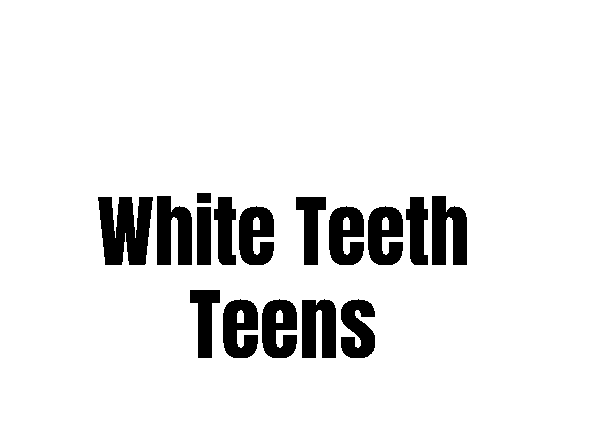

In [48]:
# b = TextBlock(text='White Teeth Teens', area=(600, 448), rand=True, hcenter=True, max_lines=2, font_size=80, font='../fonts/Anton/Anton-Regular.ttf')
# b.image